# 3. Segmentación de Clientes (Clustering no supervisado)

En este notebook vamos a crear **segmentos de clientes** usando clustering no supervisado (K-Means).

**Objetivos generales:**

- Agrupar clientes según su comportamiento de compra y perfil.
- Usar variables de valor, frecuencia, recencia, canales y hogar.
- Reconstruir la etiqueta de churn valioso (`Churn_Valioso_KMeans`) definida en el CDA.
- Cruzar los segmentos con el churn valioso.
- Guardar un dataset con el cluster asignado para usarlo después en el modelo de churn.


## 1. Carga de datos

En esta sección cargamos el dataset ya procesado en el EDA/CDA y revisamos su estructura básica.


In [49]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


In [50]:
ruta_datos = "../data/superstore_procesado.csv"
df = pd.read_csv(ruta_datos)
df.head()


,Id,Dt_Customer,Recency,CustomerTenure,MntTotal,TotalPurchases,Perc_WebPurchases,Perc_CatalogPurchases,Perc_StorePurchases,Income,Kidhome,Teenhome,Education,Marital_Status,NumWebVisitsMonth,CLV_simple,CLV_log
0,2281,2013-09-15,34,447,28,4,0.250000,0.000000,0.500000,33697.0,1,0,Graduation,Single,7,112,5.419454
1,10634,2014-04-19,56,231,406,15,0.266667,0.133333,0.533333,59412.0,0,0,Master,Married,3,6090,16.659968
2,3409,2013-10-15,68,417,339,15,0.466667,0.066667,0.266667,36108.0,1,0,Graduation,Single,9,5085,16.161269
3,7828,2014-04-30,29,220,818,12,0.250000,0.250000,0.416667,77882.0,0,0,Master,Together,1,9816,17.205896
4,2350,2013-03-22,87,624,1027,20,0.150000,0.100000,0.400000,59666.0,1,1,Graduation,Married,8,20540,21.114891


In [51]:
df.shape

(1792, 17)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1792 entries, 0 to 1791
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     1792 non-null   int64  
 1   Dt_Customer            1792 non-null   object 
 2   Recency                1792 non-null   int64  
 3   CustomerTenure         1792 non-null   int64  
 4   MntTotal               1792 non-null   int64  
 5   TotalPurchases         1792 non-null   int64  
 6   Perc_WebPurchases      1792 non-null   float64
 7   Perc_CatalogPurchases  1792 non-null   float64
 8   Perc_StorePurchases    1792 non-null   float64
 9   Income                 1770 non-null   float64
 10  Kidhome                1792 non-null   int64  
 11  Teenhome               1792 non-null   int64  
 12  Education              1792 non-null   object 
 13  Marital_Status         1792 non-null   object 
 14  NumWebVisitsMonth      1792 non-null   int64  
 15  CLV_

**Comentario:**

- Aquí confirmamos cuántos registros y columnas tenemos.
- También verificamos que las variables necesarias para la segmentación y el churn estén disponibles.


### 1.1 Reconstrucción de la etiqueta `Churn_Valioso_KMeans`

En el notebook de CDA se definió el churn valioso con:

- Clientes **inactivos**: `Recency >= 83` días.
- Clientes **valiosos**: `CLV_log` por encima de la mediana.

Aquí retomamos esa misma lógica para volver a crear las columnas:
`Churn_Valioso_KMeans` y `Churn_KMeans` a partir de las variables disponibles.


In [53]:
UMBRAL_RECENCY_KMEANS = 83
mediana_clv = df["CLV_log"].median()

df["Churn_Valioso_KMeans"] = (
    (df["Recency"] >= UMBRAL_RECENCY_KMEANS) &
    (df["CLV_log"] >= mediana_clv)
).astype(int)

df["Churn_KMeans"] = (df["Recency"] >= UMBRAL_RECENCY_KMEANS).astype(int)

df[["Recency", "CLV_log", "Churn_Valioso_KMeans", "Churn_KMeans"]].head()


,Recency,CLV_log,Churn_Valioso_KMeans,Churn_KMeans
0,34,5.419454,0,0
1,56,16.659968,0,0
2,68,16.161269,0,0
3,29,17.205896,0,0
4,87,21.114891,1,1


**Comentario:**

- Reproducimos exactamente la definición de churn del CDA.
- A partir de aquí ya podemos usar `Churn_Valioso_KMeans` en los cruces con los clusters.


## 2. Selección de variables para la segmentación

Vamos a usar variables que combinan distintos aspectos del cliente:

- **Comportamiento temporal**: `Recency`, `CustomerTenure`.
- **Valor y frecuencia**: `MntTotal`, `TotalPurchases`, `Income`.
- **Canales**: `Perc_WebPurchases`, `Perc_CatalogPurchases`, `Perc_StorePurchases`, `NumWebVisitsMonth`.
- **Estructura del hogar**: `Kidhome`, `Teenhome`.

No usamos `CLV_simple` ni `CLV_log` en el clustering para evitar duplicar la lógica del churn valioso.


In [54]:
vars_para_clustering = [
    "Recency",
    "CustomerTenure",
    "MntTotal",
    "TotalPurchases",
    "Income",
    "Perc_WebPurchases",
    "Perc_CatalogPurchases",
    "Perc_StorePurchases",
    "NumWebVisitsMonth",
    "Kidhome",
    "Teenhome"
]

df_seg = df[vars_para_clustering].copy()
df_seg.describe()


,Recency,CustomerTenure,MntTotal,TotalPurchases,Income,Perc_WebPurchases,Perc_CatalogPurchases,Perc_StorePurchases,NumWebVisitsMonth,Kidhome,Teenhome
count,1792.000000,1792.000000,1792.000000,1792.000000,1770.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000
mean,49.368304,511.534598,602.405134,14.844866,51754.841808,0.265766,0.141775,0.409008,5.329799,0.437500,0.513951
std,28.842464,231.878159,603.869370,7.754355,21800.710916,0.099223,0.129266,0.122344,2.436702,0.533103,0.549936
min,0.000000,0.000000,5.000000,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,337.000000,68.000000,7.000000,34873.500000,0.200000,0.000000,0.333333,3.000000,0.000000,0.000000
50%,50.000000,515.000000,389.000000,15.000000,51277.000000,0.250000,0.117647,0.409091,6.000000,0.000000,0.000000
75%,74.000000,682.250000,1034.000000,21.000000,68138.000000,0.333333,0.222222,0.500000,7.000000,1.000000,1.000000
max,99.000000,1063.000000,2525.000000,44.000000,162397.000000,1.000000,1.000000,1.000000,20.000000,2.000000,2.000000


**Comentario:**

- La tabla de `describe()` nos muestra rangos, medias y desviaciones estándar.
- Se ve claramente que hay escalas muy diferentes (por ejemplo, `Income` vs `Kidhome`), lo que justifica el escalado posterior.


### 2.1 Revisión de valores nulos

Revisamos valores nulos y eliminamos filas con nulos solo en estas variables, para que el clustering funcione bien.


In [55]:
df_seg.isna().sum()

Recency                   0
CustomerTenure            0
MntTotal                  0
TotalPurchases            0
Income                   22
Perc_WebPurchases         0
Perc_CatalogPurchases     0
Perc_StorePurchases       0
NumWebVisitsMonth         0
Kidhome                   0
Teenhome                  0
dtype: int64

**Comentario:**

- Identificamos si alguna variable tiene nulos.
- Si el número de nulos es pequeño, se pueden eliminar sin problema para este análisis.


In [56]:
df_seg = df_seg.dropna()
df_seg.shape


(1770, 11)

**Comentario:**

- Mostramos el nuevo `shape` después de eliminar nulos.
- Confirmamos cuántos clientes se usarán efectivamente en la segmentación.


## 3. Escalado de variables

K-Means usa distancias, así que todas las variables deben estar en una escala comparable.

Usamos **StandardScaler** para estandarizar:

- Media = 0.
- Desviación estándar = 1.


In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_seg)
X_scaled[:5]


array([[-0.528807  , -0.277994  , -0.95263901, -1.40315055, -0.82854844,
        -0.16037981, -1.10057584,  0.75290179,  0.68360205,  1.05739326,
        -0.93483646],
       [ 0.23399147, -1.20870607, -0.32713099,  0.01633096,  0.3513336 ,
         0.01033402, -0.0688914 ,  1.02759174, -0.9592705 , -0.81794348,
        -0.93483646],
       [ 0.65006336, -0.40725956, -0.43800146,  0.01633096, -0.71792446,
         2.05889997, -0.58473362, -1.16992783,  1.50503833,  1.05739326,
        -0.93483646],
       [-0.70217029, -1.25610344,  0.35463966, -0.37080036,  1.1987931 ,
        -0.16037981,  0.83383249,  0.06617693, -1.78070677, -0.81794348,
        -0.93483646],
       [ 1.30884385,  0.48467284,  0.70048933,  0.66154983,  0.36298788,
        -1.18466279, -0.32681251, -0.07116805,  1.09432019,  1.05739326,
         0.88547216]])

**Comentario:**

- Vemos las primeras filas ya escaladas.
- Ninguna variable domina solo por su escala numérica.


## 4. Elección del número de clusters (k)

Probamos varios valores de k y calculamos **inertia** y **silhouette** para cada uno.


In [58]:
rango_k = range(2, 9)
inertias = []
silhouettes = []
for k in rango_k:
    modelo = KMeans(n_clusters=k, random_state=42, n_init=10)
    etiquetas = modelo.fit_predict(X_scaled)
    inertias.append(modelo.inertia_)
    sil_score = silhouette_score(X_scaled, etiquetas)
    silhouettes.append(sil_score)


### 4.1 Curva del codo


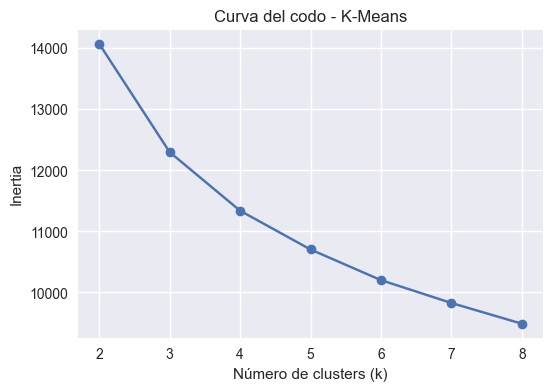

In [59]:
plt.figure(figsize=(6, 4))
plt.plot(list(rango_k), inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia')
plt.title('Curva del codo - K-Means')
plt.xticks(list(rango_k))
plt.show()


**Interpretación:**

- La *inertia* disminuye al aumentar k, pero las caídas más fuertes se dan entre **k=2→3** y **k=3→4**.
- A partir de **k=4**, la mejora es más suave (curva más plana).
- Esto indica que **k=3 o k=4** son valores razonables; usamos **k=4** por interpretabilidad de negocio.


### 4.2 Silhouette por número de clusters


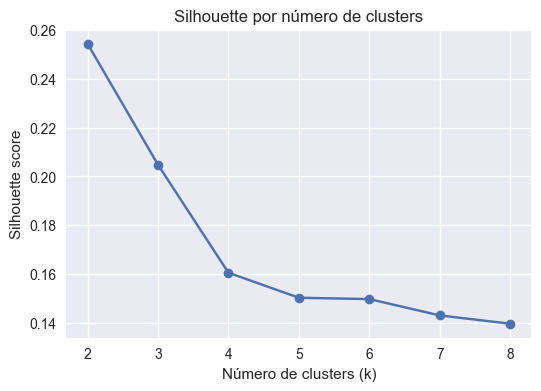

In [60]:
plt.figure(figsize=(6, 4))
plt.plot(list(rango_k), silhouettes, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette por número de clusters')
plt.xticks(list(rango_k))
plt.show()


**Interpretación:**

- El mejor silhouette está en **k=2**, pero solo dos clusters son poco útiles para segmentación de negocio.
- Entre **k=3 y k=4** el silhouette baja, pero se mantiene en un rango razonable.
- La combinación de codo + silhouette hace que **k=4** sea una elección equilibrada.


En base a estos resultados fijamos **k = 4** como número de clusters para seguir trabajando.


## 5. Entrenamiento de K-Means final

Entrenamos K-Means con `k=4` y añadimos la etiqueta de cluster al DataFrame.


In [61]:
k_final = 4
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)
df_seg['Cluster'] = clusters
df_seg['Cluster'].value_counts().sort_index()


Cluster
0    379
1    461
2    549
3    381
Name: count, dtype: int64

**Comentario:**

- Comprobamos el tamaño de cada cluster.
- En este caso los cuatro clusters tienen tamaños similares (del orden de 500–650 clientes), lo que facilita la comparación.


Unimos la columna `Cluster` al DataFrame original.


In [62]:
df_clusters = df.join(df_seg['Cluster'])
df_clusters.head()


,Id,Dt_Customer,Recency,CustomerTenure,MntTotal,TotalPurchases,Perc_WebPurchases,Perc_CatalogPurchases,Perc_StorePurchases,Income,Kidhome,Teenhome,Education,Marital_Status,NumWebVisitsMonth,CLV_simple,CLV_log,Churn_Valioso_KMeans,Churn_KMeans,Cluster
0,2281,2013-09-15,34,447,28,4,0.250000,0.000000,0.500000,33697.0,1,0,Graduation,Single,7,112,5.419454,0,0,1.0
1,10634,2014-04-19,56,231,406,15,0.266667,0.133333,0.533333,59412.0,0,0,Master,Married,3,6090,16.659968,0,0,0.0
2,3409,2013-10-15,68,417,339,15,0.466667,0.066667,0.266667,36108.0,1,0,Graduation,Single,9,5085,16.161269,0,0,3.0
3,7828,2014-04-30,29,220,818,12,0.250000,0.250000,0.416667,77882.0,0,0,Master,Together,1,9816,17.205896,0,0,0.0
4,2350,2013-03-22,87,624,1027,20,0.150000,0.100000,0.400000,59666.0,1,1,Graduation,Married,8,20540,21.114891,1,1,2.0


**Comentario:**

- `df_clusters` será la base para el perfilado y el cruce con churn.


## 6. Perfilado de segmentos

Analizamos el tamaño y los promedios de cada cluster.


In [63]:
conteo_clusters = df_clusters['Cluster'].value_counts().sort_index()
conteo_clusters


Cluster
0.0    379
1.0    461
2.0    549
3.0    381
Name: count, dtype: int64

**Comentario:**

- Confirmamos que todos los clusters tienen cientos de clientes.
- Ningún segmento es residual o demasiado pequeño.


In [64]:
columnas_resumen = vars_para_clustering + ['Cluster']
resumen_clusters = (
    df_clusters[columnas_resumen]
    .groupby('Cluster')
    .mean()
    .round(2)
)
resumen_clusters


,Recency,CustomerTenure,MntTotal,TotalPurchases,Income,Perc_WebPurchases,Perc_CatalogPurchases,Perc_StorePurchases,NumWebVisitsMonth,Kidhome,Teenhome
Cluster,,,,,,,,,,,
0.0,50.21,490.26,1394.09,20.25,77949.73,0.22,0.31,0.40,2.36,0.04,0.07
1.0,45.94,406.69,64.45,6.52,35472.14,0.21,0.04,0.51,5.76,0.76,0.52
2.0,48.47,557.68,808.05,20.90,60320.32,0.31,0.16,0.38,5.47,0.13,0.95
3.0,53.43,592.99,175.42,10.95,33056.72,0.31,0.08,0.34,7.58,0.88,0.32


**Comentario:**

- Esta tabla resume el comportamiento promedio de cada cluster en todas las variables.
- A partir de aquí podemos empezar a construir perfiles cualitativos de cada segmento.


### 6.1 Variables de valor y comportamiento


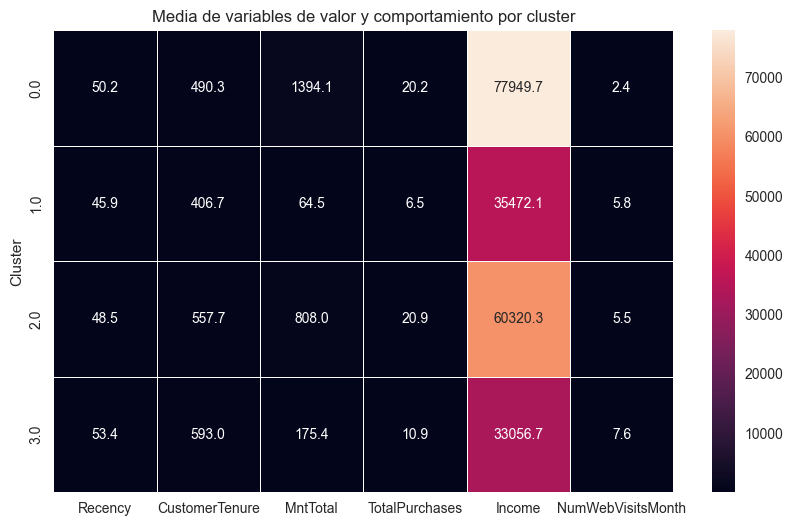

In [65]:
vars_valor = ['Recency','CustomerTenure','MntTotal','TotalPurchases','Income','NumWebVisitsMonth']
plt.figure(figsize=(10,6))
sns.heatmap(resumen_clusters[vars_valor], annot=True, fmt='.1f', linewidths=0.5)
plt.title('Media de variables de valor y comportamiento por cluster')
plt.ylabel('Cluster')
plt.show()


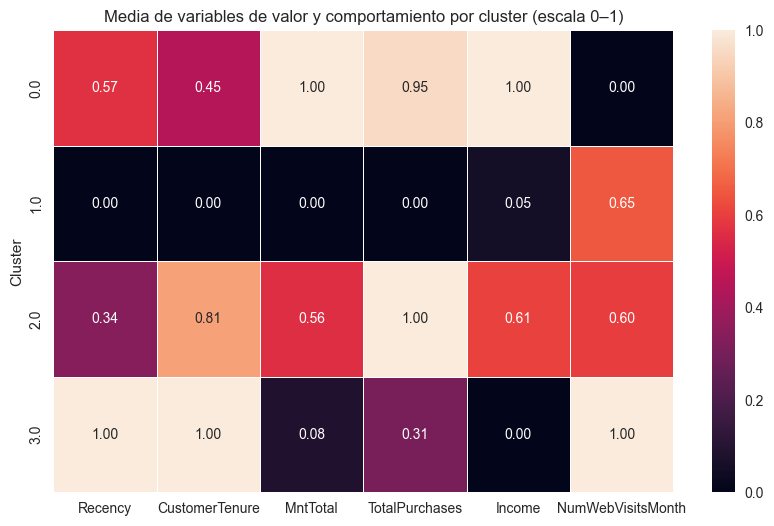

In [73]:
# Copiamos para no dañar el original
resumen_valor_norm = resumen_clusters[vars_valor].copy()

# Normalizamos cada columna entre 0 y 1 (min–max por variable)
for col in vars_valor:
    col_min = resumen_valor_norm[col].min()
    col_max = resumen_valor_norm[col].max()
    resumen_valor_norm[col] = (resumen_valor_norm[col] - col_min) / (col_max - col_min)

plt.figure(figsize=(10, 6))
sns.heatmap(
    resumen_valor_norm,
    annot=True,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Media de variables de valor y comportamiento por cluster (escala 0–1)")
plt.ylabel("Cluster")
plt.show()


**Nota sobre este heatmap:**

- Aquí cada columna está normalizada entre 0 y 1 (0 = valor más bajo entre clusters, 1 = más alto).
- Ya no vemos el valor real de ingreso, gasto, etc., sino la **intensidad relativa** dentro de cada variable.
- Esto evita que `Income` “aplane” el resto y permite ver mejor qué cluster es más alto o más bajo en cada métrica.


**Interpretación:**

- **Cluster 2** tiene el mayor *Income* y el mayor *MntTotal*: es el segmento **premium**.
- **Cluster 1** muestra la mayor *frecuencia* de compra (*TotalPurchases* ≈ 21): clientes muy activos.
- **Cluster 0** y **Cluster 3** tienen valores de gasto y frecuencia mucho más bajos: segmentos de **bajo valor**.
- **Cluster 0** tiene más visitas web; **Cluster 2** casi no visita la web, lo que refuerza la idea de cliente tradicional.


### 6.2 Mix de canales


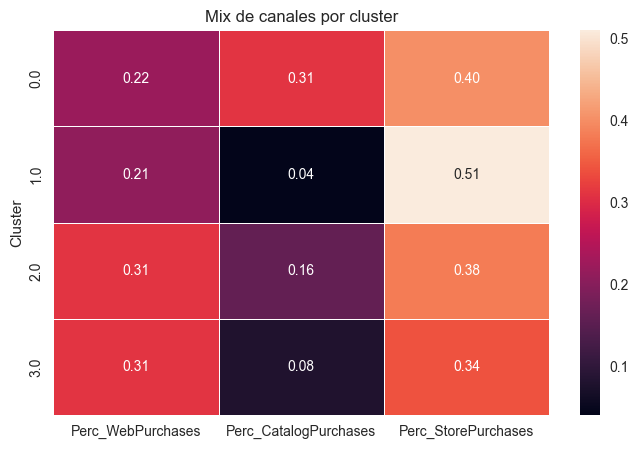

In [66]:
vars_canales = ['Perc_WebPurchases','Perc_CatalogPurchases','Perc_StorePurchases']
plt.figure(figsize=(8,5))
sns.heatmap(resumen_clusters[vars_canales], annot=True, fmt='.2f', linewidths=0.5)
plt.title('Mix de canales por cluster')
plt.ylabel('Cluster')
plt.show()


**Interpretación:**

- **Cluster 2** usa más *catálogo* (≈0.31) y *tienda física*, lo que refuerza el perfil tradicional/premium.
- **Cluster 1** tiene un mix equilibrado entre web y tienda, típico de cliente omnicanal.
- **Cluster 3** es el más orientado a *tienda física* (≈0.52).
- **Cluster 0** combina web y tienda, con poco uso de catálogo.


### 6.3 Composición del hogar


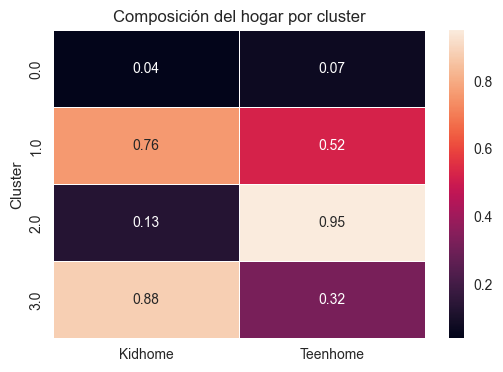

In [67]:
vars_hogar = ['Kidhome','Teenhome']
plt.figure(figsize=(6,4))
sns.heatmap(resumen_clusters[vars_hogar], annot=True, fmt='.2f', linewidths=0.5)
plt.title('Composición del hogar por cluster')
plt.ylabel('Cluster')
plt.show()


**Interpretación:**

- **Cluster 0** tiene muchos niños pequeños (*Kidhome* alto): familias jóvenes.
- **Cluster 1** tiene muchos adolescentes (*Teenhome* alto): familias con hijos mayores.
- **Cluster 2** prácticamente no tiene niños ni adolescentes: adultos independientes.
- **Cluster 3** mezcla niños y adolescentes en el hogar.


## 7. Interpretación rápida de segmentos

A partir de las medias por cluster, podemos resumir cada segmento:

- **Cluster 0 – Familias jóvenes y de bajo valor**  
  Income bajo, gasto y frecuencia bajos, más compras en tienda, muchos niños y bastante uso web.

- **Cluster 1 – Clientes fieles de ticket medio con adolescentes**  
  Income alto, frecuencia elevada, mix equilibrado web/tienda y muchos adolescentes en el hogar.

- **Cluster 2 – Clientes premium tradicionales (catálogo + tienda)**  
  Income muy alto, gasto elevado, más catálogo y tienda, pocas visitas web y casi sin hijos.

- **Cluster 3 – Clientes de muy bajo valor y compras físicas**  
  Income bajo, gasto y frecuencia muy bajos, fuerte dependencia de tienda física, hogares con niños y adolescentes.


## 8. Cruce de clusters con Churn Valioso

Cruzamos los clusters con la etiqueta `Churn_Valioso_KMeans` para ver qué segmentos concentran más churn valioso.


In [68]:
df_clusters['Churn_Valioso_KMeans'].value_counts()


Churn_Valioso_KMeans
0    1642
1     150
Name: count, dtype: int64

**Comentario:**

- Vemos la cantidad total de clientes marcados como churn valioso (1) frente a no churn (0).


In [69]:
tabla_cruce = pd.crosstab(df_clusters['Cluster'], df_clusters['Churn_Valioso_KMeans'])
tabla_cruce


Churn_Valioso_KMeans,0,1
Cluster,,
0.0,317,62
1.0,461,0
2.0,471,78
3.0,374,7


**Comentario:**

- Esta tabla muestra el número de clientes churn/no churn valioso en cada cluster.
- Nos da una primera idea del volumen de riesgo por segmento.


In [70]:
tabla_cruce_pct = pd.crosstab(
    df_clusters['Cluster'],
    df_clusters['Churn_Valioso_KMeans'],
    normalize='index'
).round(3)
tabla_cruce_pct


Churn_Valioso_KMeans,0,1
Cluster,,
0.0,0.836,0.164
1.0,1.000,0.000
2.0,0.858,0.142
3.0,0.982,0.018


**Comentario:**

- Aquí vemos el **porcentaje** de churn valioso dentro de cada cluster.
- Esto es más informativo que los valores absolutos para comparar el riesgo relativo.


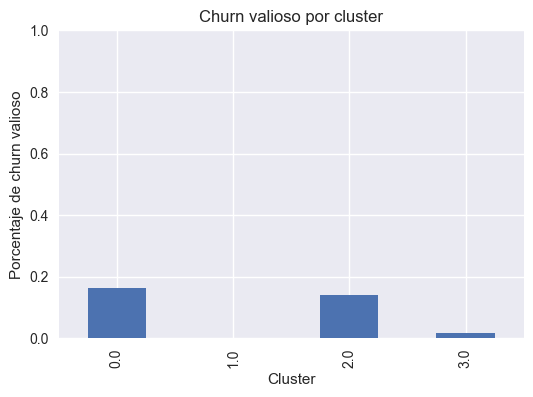

In [71]:
tabla_cruce_pct[1].plot(kind='bar', figsize=(6,4))
plt.ylabel('Porcentaje de churn valioso')
plt.xlabel('Cluster')
plt.title('Churn valioso por cluster')
plt.ylim(0,1)
plt.show()


**Interpretación:**

- El churn valioso se concentra principalmente en los **clusters 1 y 2**, con porcentajes alrededor de 14–17%.
- Los clusters 0 y 3 tienen porcentajes menores al 2%: prácticamente no aportan churn valioso.
- Esto indica que el churn valioso **no es aleatorio**, sino que está ligado a perfiles concretos.


## 9. Guardar dataset segmentado

Guardamos el dataset con la columna `Cluster` para usarlo después en el modelo supervisado de churn valioso.


In [72]:
ruta_salida = "../data/superstore_segmentado.csv"
df_clusters.to_csv(ruta_salida, index=False)
ruta_salida


'../data/superstore_segmentado.csv'

**Comentario:**

- El archivo `superstore_segmentado.csv` contiene ahora todas las variables originales, las etiquetas de churn y el cluster asignado.


## 10. Conclusiones del notebook

- Se creó una segmentación clara con **k=4** clusters equilibrados.
- Los segmentos presentan diferencias marcadas en valor económico, frecuencia de compra, canales utilizados y composición del hogar.
- El **churn valioso** no está distribuido al azar: se concentra en los clusters **1 y 2**, que corresponden a clientes de valor medio-alto y premium.
- Los clusters **0 y 3** representan clientes de bajo valor y apenas aportan churn valioso, por lo que no son prioridad en retención.
- El cluster **2** (clientes premium tradicionales) es el más crítico, con el mayor porcentaje de churn valioso.
- El cluster **1** (clientes de alta frecuencia con adolescentes) también muestra un riesgo relevante.
- Este análisis deja listo el dataset para el siguiente paso del proyecto: construir un **modelo supervisado de churn valioso** que permita anticipar el abandono en estos segmentos clave.
